In [1]:
import os
import datetime

import sys

sys.path.append("..")

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from functions import df_security_code, missingValues

import tensorflow as tf

from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Data

In [2]:
data = pd.read_csv('../data/curr_price_financial_fill.csv', parse_dates=['Date'],  index_col=[0])
df = df_security_code(data)
del data

In [3]:
df.head(2)

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month_sin,Month_cos,Year_sin,Year_cos,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
0,20170104_7203,2017-01-04,7203,0.0,0,7010.0,7103.0,6975.0,7097.0,9547600.0,...,0.046905,-0.998899,0.061933,0.998080,NaN,NaN,NaN,NaN,NaN,NaN
1,20170105_7203,2017-01-05,7203,0.0,0,7090.0,7091.0,7023.0,7049.0,7644000.0,...,-0.158971,-0.987283,0.079093,0.996867,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns
df = df.iloc[:,5:]
df.drop(['margin_growth', 'win_quarter_growth', 'margin', 'NetSales', 'Profit',
       'Day_cos', 'Year', 'rev_quarter_growth'], axis = 1, inplace=True)

In [5]:
df.head(2)

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,ad_Close_lag1,ad_Close_sma10,logprice_ad_Close,detrend_ad_Close,...,macd_s,Day,Month,week,Volatility_week,Day_sin,Month_sin,Month_cos,Year_sin,Year_cos
0,7010.0,7103.0,6975.0,7097.0,9547600.0,-0.016882,NaN,NaN,8.867427,7097.0,...,NaN,4.0,1.0,1.0,1.619015,-1.405899e-12,0.046905,-0.998899,0.061933,0.998080
1,7090.0,7091.0,7023.0,7049.0,7644000.0,-0.009957,7097.0,NaN,8.860641,7049.0,...,NaN,5.0,1.0,1.0,1.619015,-1.165928e-11,-0.158971,-0.987283,0.079093,0.996867


# Preparation for modelling

## - Train Test Split


In [6]:
def split_train_val_test(df, split=22):
    df.dropna(inplace=True)
    df_train =  df[:- 2*split]
    df_val = df[- 2*split : - split]
    df_test = df[- split : ]
    #

    #df_train =  df[:(len(df)-2*split)]
    #df_val = df[(len(df)-2*split):(len(df)-split)]
    #df_test =  df[(len(df)-split):]




    return df_train, df_val, df_test

In [7]:
train_data, val_data, test_data = split_train_val_test(df=df)
print(df.shape)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1169, 50)
(1125, 50)
(22, 50)
(22, 50)


In [8]:
#val_data.describe().T

## - Scaling

In [9]:
def scaling_df(df):

    scaler = StandardScaler()
    scaler2 = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = scaler2.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = df.columns
    
    #df_mean = df.mean()
    #df_std = df.std()

    #df_scaled = (df-df_mean) / df_std 
    
    return df_scaled

In [10]:
train_df = scaling_df(train_data)
val_df = scaling_df(val_data)
test_df = scaling_df(test_data)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1125, 50)
(22, 50)
(22, 50)


In [11]:
num_features = train_df.shape[1]

In [12]:
val_df.ad_Close.describe()

count    22.000000
mean      0.639177
std       0.255075
min       0.000000
25%       0.531548
50%       0.688095
75%       0.779167
max       1.000000
Name: ad_Close, dtype: float64

In [13]:
#sns.histplot(val_df.ad_Close, bins=10)

In [14]:
val_df.ad_Close.mean()

0.6391774891774893

In [15]:
val_df.describe().T.sort_values('std', ascending=True)

,count,mean,std,min,25%,50%,75%,max
Month,22.0,0.045455,0.213201,0.0,0.000000,0.000000,0.000000,1.0
ad_High_lag1,22.0,0.565073,0.235605,0.0,0.521226,0.593160,0.668042,1.0
ad_Open_lag1,22.0,0.535439,0.235689,0.0,0.396186,0.576271,0.683263,1.0
error_ad_High,22.0,0.592587,0.242696,0.0,0.485026,0.617833,0.753817,1.0
error_ad_Close,22.0,0.627733,0.247229,0.0,0.530651,0.658764,0.745712,1.0
logprice_ad_High,22.0,0.642765,0.253299,0.0,0.605412,0.686303,0.769862,1.0
ad_High,22.0,0.634775,0.253702,0.0,0.594086,0.676075,0.761425,1.0
detrend_ad_High,22.0,0.634775,0.253702,0.0,0.594086,0.676075,0.761425,1.0
ad_Volume,22.0,0.292597,0.253905,0.0,0.104625,0.225019,0.420702,1.0
error_ad_Open,22.0,0.595259,0.254375,0.0,0.431097,0.620798,0.743097,1.0


In [16]:
missingValues(train_df)
missingValues(val_df)
missingValues(test_df)

,N_missing,Percentage


,N_missing,Percentage


,N_missing,Percentage


## - Window

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
#w1 = WindowGenerator(input_width=22, label_width=1, shift=1,
                     #label_columns=['ad_Close'])
#w1

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
"""example_window = tf.stack([np.array(train_data[:w1.total_window_size]),
                           np.array(train_data[100:100+w1.total_window_size]),
                           np.array(train_data[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')"""

"example_window = tf.stack([np.array(train_data[:w1.total_window_size]),\n                           np.array(train_data[100:100+w1.total_window_size]),\n                           np.array(train_data[200:200+w1.total_window_size])])\n\nexample_inputs, example_labels = w1.split_window(example_window)\n\nprint('All shapes are: (batch, time, features)')\nprint(f'Window shape: {example_window.shape}')\nprint(f'Inputs shape: {example_inputs.shape}')\nprint(f'Labels shape: {example_labels.shape}')"

In [21]:
#w1.example = example_inputs, example_labels

In [22]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [23]:
#w1.plot()

In [24]:
#w1.plot(plot_col='ad_Target')

### create dataset

In [25]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

### train , val , test

In [26]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
# Each element is an (inputs, label) pair.
#w1.train.element_spec

In [28]:
"""for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')"""

"for example_inputs, example_labels in w1.train.take(1):\n  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')\n  print(f'Labels shape (batch, time, features): {example_labels.shape}')"

# Modelling

In [29]:
train_performance ={}
val_performance = {}
performance = {}

## single step

In [30]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ad_Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ad_Close']

In [31]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    #mode='min'
                                                    )

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping]
                      )
  return history

### - Baseline

In [32]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [33]:
baseline = Baseline(label_index=single_step_window.column_indices['ad_Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


train_performance['Baseline_S'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline_S'] = baseline.evaluate(single_step_window.val)
performance['Baseline_S'] = baseline.evaluate(single_step_window.test, verbose=0)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-27 21:07:54.705667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 21:07:54.705786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-27 21:07:54.803194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-27 21:07:54.871111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 29ms/step - loss: 0.0265 - mean_absolute_error: 0.1333


### - Linear

In [34]:
linear = tf.keras.Sequential([
    #tf.keras.layers.Normalization(axis=None), 

    tf.keras.layers.Dense(units=1)
])

In [35]:
history_l_s = compile_and_fit(linear, single_step_window)

Epoch 1/20
12/36 [=========>....................] - ETA: 0s - loss: 0.1573 - mean_absolute_error: 0.3031

2022-04-27 21:07:55.413068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 11ms/step - loss: 0.1054 - mean_absolute_error: 0.2496 - val_loss: 0.1723 - val_mean_absolute_error: 0.3183
Epoch 2/20
23/36 [==================>...........] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1998

2022-04-27 21:07:55.815457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 6ms/step - loss: 0.0578 - mean_absolute_error: 0.1907 - val_loss: 0.1660 - val_mean_absolute_error: 0.3096
Epoch 3/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0378 - mean_absolute_error: 0.1545 - val_loss: 0.1838 - val_mean_absolute_error: 0.3272
Epoch 4/20
36/36 [==============================] - 0s 6ms/step - loss: 0.0274 - mean_absolute_error: 0.1321 - val_loss: 0.1966 - val_mean_absolute_error: 0.3369


In [36]:
train_performance['Linear_S'] = linear.evaluate(single_step_window.train)
val_performance['Linear_S'] = linear.evaluate(single_step_window.val)
performance['Linear_S'] = linear.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 25ms/step - loss: 0.1966 - mean_absolute_error: 0.3369


### - Dense

In [37]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [38]:
history_d_s = compile_and_fit(dense, single_step_window)


train_performance['Dense_s'] = dense.evaluate(single_step_window.train)
val_performance['Dense_s'] = dense.evaluate(single_step_window.val)
performance['Dense_s'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
 7/36 [====>.........................] - ETA: 0s - loss: 0.0940 - mean_absolute_error: 0.2326 

2022-04-27 21:07:57.286879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 12ms/step - loss: 0.0332 - mean_absolute_error: 0.1280 - val_loss: 0.0690 - val_mean_absolute_error: 0.2187
Epoch 2/20
13/36 [=========>....................] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0530

2022-04-27 21:07:57.762529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_absolute_error: 0.0455 - val_loss: 0.0612 - val_mean_absolute_error: 0.2020
Epoch 3/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0331 - val_loss: 0.0631 - val_mean_absolute_error: 0.2109
Epoch 4/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0288 - val_loss: 0.0555 - val_mean_absolute_error: 0.1958
Epoch 5/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0268 - val_loss: 0.0577 - val_mean_absolute_error: 0.2038
Epoch 6/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0257 - val_loss: 0.0487 - val_mean_absolute_error: 0.1789
Epoch 7/20
36/36 [==============================] - 0s 9ms/step - loss: 9.8074e-04 - mean_absolute_error: 0.0241 - val_loss: 0.0507 - val_mean_absolute_error: 0.1863
Epoch 8/20
36/36 [================

In [39]:
pd.DataFrame(performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]']).T


,Mean Squared Error [ad_Close],Mean Absolute error [ad_Close]
Baseline_S,0.038627,0.163497
Linear_S,0.134192,0.273088
Dense_s,0.047820,0.177840


### - Multistep dense

In [40]:
CONV_WIDTH = 10 #3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ad_Close'])

conv_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['ad_Close']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

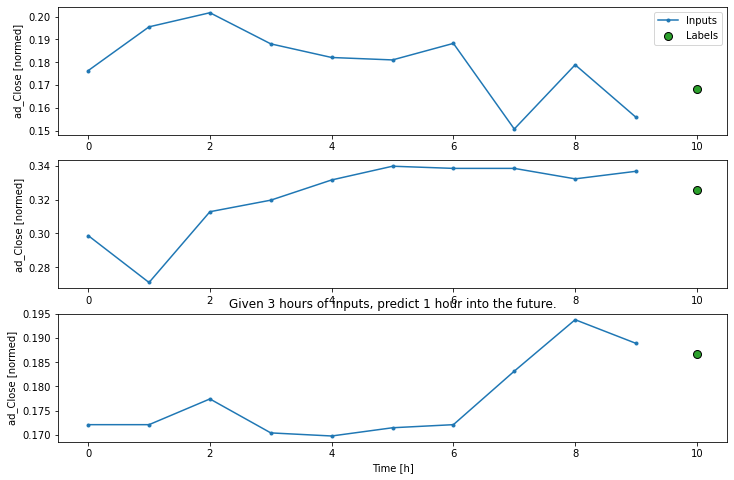

In [41]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [42]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [43]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 10, 50)
Output shape: (32, 1, 1)


In [44]:
history_msd = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 27ms/step - loss: 0.0441 - mean_absolute_error: 0.1821


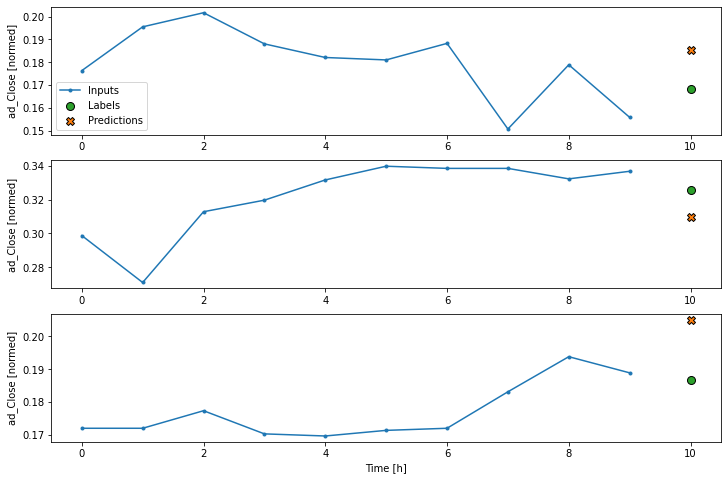

In [45]:
conv_window.plot(multi_step_dense)


### - Convolutional

In [46]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [47]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 10, 50)
Output shape: (32, 1, 1)


In [48]:
history_conv = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 28ms/step - loss: 0.0741 - mean_absolute_error: 0.2322


### - Conv larger window

In [49]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ad_Close'])

wide_conv_window

Total window size: 34
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Label indices: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
Label column name(s): ['ad_Close']

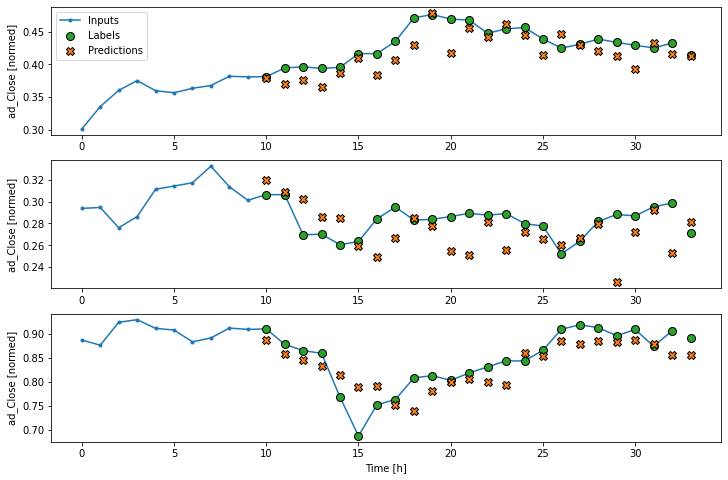

In [50]:
wide_conv_window.plot(conv_model)

### - LSTM

In [51]:
wide_window = WindowGenerator(
    input_width=10, label_width=1, shift=1,
    label_columns=['ad_Close'])

wide_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['ad_Close']

In [52]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [53]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 10, 50)
Output shape: (32, 10, 1)


In [54]:
history_lstm = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 27ms/step - loss: 0.1371 - mean_absolute_error: 0.3189


- residual wrapper

In [55]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [56]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 31ms/step - loss: 0.1664 - mean_absolute_error: 0.3292
CPU times: user 7.27 s, sys: 2.51 s, total: 9.79 s
Wall time: 7.71 s


In [57]:
pd.DataFrame(performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]']).T


,Mean Squared Error [ad_Close],Mean Absolute error [ad_Close]
Baseline_S,0.038627,0.163497
Linear_S,0.134192,0.273088
Dense_s,0.047820,0.177840
Multi step dense,0.113365,0.268474
Conv,0.132794,0.283665
LSTM,0.263777,0.433899
Residual LSTM,0.291899,0.455046


In [58]:
pd.DataFrame(val_performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]']).T


,Mean Squared Error [ad_Close],Mean Absolute error [ad_Close]
Baseline_S,0.026460,0.133333
Linear_S,0.196571,0.336888
Dense_s,0.048983,0.183594
Multi step dense,0.044142,0.182089
Conv,0.074120,0.232172
LSTM,0.137070,0.318853
Residual LSTM,0.166404,0.329248


### helper functions


In [59]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [60]:
train_performance ={}
val_performance = {}
performance = {}

# Fit Test


## - Single step models:

predict a single features value 1 time step into future

In [61]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ad_Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ad_Close']

In [62]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 50)
Labels shape (batch, time, features): (32, 1, 1)


- Baseline

In [63]:
baseline = Baseline(label_index=single_step_window.column_indices['ad_Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


train_performance['Baseline_S'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline_S'] = baseline.evaluate(single_step_window.val)
performance['Baseline_S'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 28ms/step - loss: 0.0265 - mean_absolute_error: 0.1333


2022-04-27 21:08:20.863982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### - linear

In [64]:
history_l_s = compile_and_fit(linear, single_step_window)

##val_performance['Linear'] = linear.evaluate(w1.val)
#performance['Linear'] = linear.evaluate(w1.test, verbose=0)

Epoch 1/20
17/36 [=============>................] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.1172

2022-04-27 21:08:21.313627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 8ms/step - loss: 0.0198 - mean_absolute_error: 0.1132 - val_loss: 0.1917 - val_mean_absolute_error: 0.3278
Epoch 2/20
21/36 [================>.............] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0976

2022-04-27 21:08:21.618932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 6ms/step - loss: 0.0136 - mean_absolute_error: 0.0935 - val_loss: 0.2132 - val_mean_absolute_error: 0.3502
Epoch 3/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0791 - val_loss: 0.2032 - val_mean_absolute_error: 0.3386


In [65]:
pd.DataFrame(history_l_s.history)



,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.019811,0.113187,0.191749,0.327806
1,0.013573,0.093487,0.213213,0.350225
2,0.009672,0.079059,0.203191,0.338648


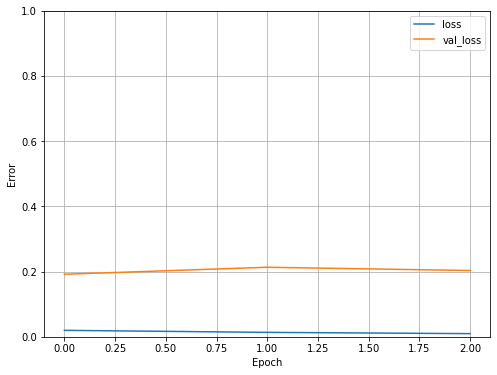

In [66]:
plot_loss(history_l_s)

In [67]:
#single_step_window.plot(linear)

In [68]:
"""plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)"""

'plt.bar(x = range(len(train_df.columns)),\n        height=linear.layers[0].kernel[:,0].numpy())\naxis = plt.gca()\naxis.set_xticks(range(len(train_df.columns)))\n_ = axis.set_xticklabels(train_df.columns, rotation=90)'

In [69]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 50), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [70]:
type(single_step_window.train.get_single_element)

method

In [71]:
type(single_step_window.train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [72]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(type(example_inputs))
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 50)
<class 'tensorflow.python.framework.ops.EagerTensor'>
Labels shape (batch, time, features): (32, 1, 1)


In [73]:
train_performance['Linear_S'] = linear.evaluate(single_step_window.train)
val_performance['Linear_S'] = linear.evaluate(single_step_window.val)
performance['Linear_S'] = linear.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 48ms/step - loss: 0.2032 - mean_absolute_error: 0.3386


- Dense

In [74]:
history_d_s = compile_and_fit(dense, single_step_window)

val_performance['Dense_d_s'] = dense.evaluate(single_step_window.val)
performance['Dense_d_s'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
 7/36 [====>.........................] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0315     

2022-04-27 21:08:23.612391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0260 - val_loss: 0.0487 - val_mean_absolute_error: 0.1850
Epoch 2/20
15/36 [===========>..................] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0250    

2022-04-27 21:08:24.079981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 9ms/step - loss: 8.9802e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0458 - val_mean_absolute_error: 0.1750
Epoch 3/20
36/36 [==============================] - 0s 9ms/step - loss: 6.1369e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0453 - val_mean_absolute_error: 0.1788
Epoch 4/20
36/36 [==============================] - 0s 9ms/step - loss: 5.6639e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0449 - val_mean_absolute_error: 0.1769
Epoch 5/20
36/36 [==============================] - 0s 9ms/step - loss: 5.3719e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0481 - val_mean_absolute_error: 0.1873
Epoch 6/20
1/1 [==============================] - 0s 31ms/step - loss: 0.0481 - mean_absolute_error: 0.1869


In [75]:
performance

{'Baseline_S': [0.03862706944346428, 0.16349749267101288],
 'Linear_S': [0.11213571578264236, 0.2645963132381439],
 'Dense_d_s': [0.05072940140962601, 0.1794167459011078]}

In [76]:
"""x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
#train_mae = [v[metric_index] for v in train_performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()"""

"x = np.arange(len(performance))\nwidth = 0.3\nmetric_name = 'mean_absolute_error'\nmetric_index = linear.metrics_names.index('mean_absolute_error')\nval_mae = [v[metric_index] for v in val_performance.values()]\ntest_mae = [v[metric_index] for v in performance.values()]\n#train_mae = [v[metric_index] for v in train_performance.values()]\n\nplt.ylabel('mean_absolute_error [T (degC), normalized]')\nplt.bar(x - 0.17, val_mae, width, label='Validation')\nplt.bar(x + 0.17, test_mae, width, label='Test')\nplt.xticks(ticks=x, labels=performance.keys(),\n           rotation=45)\n_ = plt.legend()"

## - w1

In [77]:
w1 = WindowGenerator(input_width=22, label_width=1, shift=1,
                     label_columns=['ad_Close'])

In [78]:
example_window = tf.stack([np.array(train_data[:w1.total_window_size]),
                           np.array(train_data[100:100+w1.total_window_size]),
                           np.array(train_data[200:200+w1.total_window_size])])
#example_inputs, example_labels = w1.split_window(example_window)

In [79]:
"""for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')"""

"for example_inputs, example_labels in w1.train.take(1):\n  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')\n  print(f'Labels shape (batch, time, features): {example_labels.shape}')"

In [80]:
#w1.example = example_inputs, example_labels

In [81]:
#w1.plot()

In [82]:
w1.train.element_spec

(TensorSpec(shape=(None, 22, 50), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [83]:
"""for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(type(example_inputs))
  print(f'Labels shape (batch, time, features): {example_labels.shape}')"""

"for example_inputs, example_labels in w1.train.take(1):\n  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')\n  print(type(example_inputs))\n  print(f'Labels shape (batch, time, features): {example_labels.shape}')"

In [84]:
len(example_inputs)

32

In [85]:
history_b_w = compile_and_fit(baseline, w1)

Epoch 1/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 2/20
 1/35 [..............................] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0500

2022-04-27 21:08:26.592411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 3/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 4/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 5/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 7/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 8/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 9/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 10/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 11/20
35/35 [==========

In [86]:
pd.DataFrame(history_b_w.history)

,loss,mean_absolute_error
0,0.004709,0.049164
1,0.004709,0.049164
2,0.004709,0.049164
3,0.004709,0.049164
4,0.004709,0.049164
5,0.004709,0.049164
6,0.004709,0.049164
7,0.004709,0.049164
8,0.004709,0.049164
9,0.004709,0.049164


In [87]:

#val_performance['Baseline'] = baseline.evaluate(w1.val)
#performance['Baseline_w'] = baseline.evaluate(example_inputs,example_labels , verbose=0)

In [88]:
#baseline.predict(example_inputs)

In [89]:
w1.train

<MapDataset element_spec=(TensorSpec(shape=(None, 22, 50), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [90]:
history_l_w = compile_and_fit(linear, w1)
#performance['Linear_w'] = linear.evaluate(example_inputs,example_labels , verbose=0)

Epoch 1/20
20/35 [================>.............] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0772

2022-04-27 21:08:30.277544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0765
Epoch 2/20
35/35 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_absolute_error: 0.0687
Epoch 3/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_error: 0.0631
Epoch 4/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_error: 0.0599
Epoch 5/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0561
Epoch 6/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_absolute_error: 0.0540
Epoch 7/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0516
Epoch 8/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0500
Epoch 9/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0041 - mean_absolute_error: 0.0483
Epoch 10/20
35/35 [===========

In [91]:
pd.DataFrame(history_l_w.history)

,loss,mean_absolute_error
0,0.009353,0.076471
1,0.007635,0.068663
2,0.006577,0.063086
3,0.006000,0.059933
4,0.005321,0.056102
5,0.004996,0.053994
6,0.004588,0.051552
7,0.004360,0.050026
8,0.004113,0.048317
9,0.003842,0.046549


In [92]:
#plot_loss(history_l_w)

In [93]:
for example_inputs, example_labels in w1.test.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(type(example_inputs))
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [94]:
train_performance['Linear_w'] = linear.evaluate(w1.train)
#val_performance['Linear_w'] = linear.evaluate(w1.val)
#performance['Linear_w'] = linear.evaluate(example_inputs,example_labels)
#performance['Linear_w'] = linear.evaluate(w1.test)

35/35 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0395


2022-04-27 21:08:35.023171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [95]:
performance

{'Baseline_S': [0.03862706944346428, 0.16349749267101288],
 'Linear_S': [0.11213571578264236, 0.2645963132381439],
 'Dense_d_s': [0.05072940140962601, 0.1794167459011078]}

In [96]:
'''x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x , val_mae, width, label='Validation')
plt.bar(x , test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()'''

"x = np.arange(len(performance))\nwidth = 0.3\nmetric_name = 'mean_absolute_error'\nmetric_index = linear.metrics_names.index('mean_absolute_error')\nval_mae = [v[metric_index] for v in val_performance.values()]\ntest_mae = [v[metric_index] for v in performance.values()]\n\nplt.ylabel('mean_absolute_error [T (degC), normalized]')\nplt.bar(x , val_mae, width, label='Validation')\nplt.bar(x , test_mae, width, label='Test')\nplt.xticks(ticks=x, labels=performance.keys(),\n           rotation=45)\n_ = plt.legend()"

In [97]:
pd.DataFrame(performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]']).T


,Mean Squared Error [ad_Close],Mean Absolute error [ad_Close]
Baseline_S,0.038627,0.163497
Linear_S,0.112136,0.264596
Dense_d_s,0.050729,0.179417
